In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import filtfilt

from deepinvhessian.imaging import angle_gather

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Velocity model
inputvolve = np.load('../data/Velocities.npz')
velback = inputvolve["vback"]
print(velback.shape)
x = inputvolve["x"]
z = inputvolve["z"]
r = inputvolve["recs"].T

velback_no_water = np.copy(velback)
velback_no_water[velback_no_water==1480] = 1800
model_init = gaussian_filter(velback_no_water, sigma=60)
model_init = cv2.resize(model_init, (516, 360))

nz, nx = 360, 516
dx = 12.5

(900, 1290)


In [3]:
# Create folder to save the results
folder_name = 'Results_Volve'
if os.path.isdir(folder_name) is False:
    os.makedirs(folder_name)

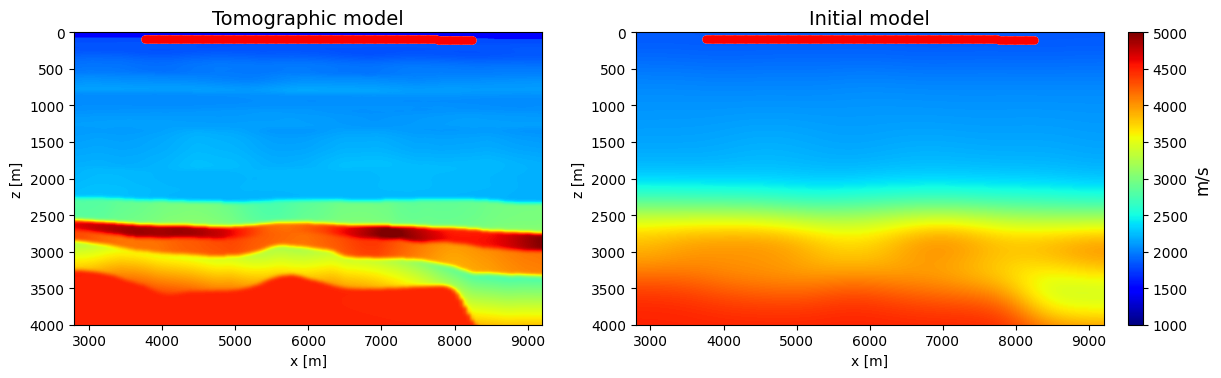

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
im1 = axs[0].imshow(velback, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].plot(r[0], r[1], '.w', ms=10)
axs[0].plot(r[0], r[1], '.r', ms=10)
axs[0].set_xlim(2800, 9200)
axs[0].set_ylim(4000, 0)
axs[0].set_title('Tomographic model', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(model_init, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[1].plot(r[0], r[1], '.w', ms=10)
axs[1].plot(r[0], r[1], '.r', ms=10)
axs[1].set_xlim(2800, 9200)
axs[1].set_ylim(4000, 0)
axs[1].set_title('Initial model', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.38, pad=0.02).set_label(label='m/s',size=12)
plt.savefig(f'{folder_name}/volve.png', bbox_inches='tight', dpi=300)

In [5]:
exp1 = 'Exp_Volve_BB'
exp2 = 'Exp_Volve_LBFGS'
exp3 = 'Exp_Volve_dm'

In [6]:
loss_bb = np.load(f'{exp1}/data_loss.npy')
loss_bb[:20] /= loss_bb[0]
loss_bb[20:40] /= loss_bb[20]
loss_bb[40:] /= loss_bb[40]

loss_lbfgs_4hz = np.load(f'{exp2}/data_loss_4Hz.npy')
loss_lbfgs_4hz /= loss_lbfgs_4hz.max()
nWE4 = np.load(f'{exp2}/nWE_4Hz.npy')
nWE4 = np.concatenate([[0], nWE4])
loss_lbfgs_7hz = np.load(f'{exp2}/data_loss_7Hz.npy')
loss_lbfgs_7hz /= loss_lbfgs_7hz.max()
nWE7 = np.load(f'{exp2}/nWE_7Hz.npy')
nWE7 = np.concatenate([[0], nWE7])
loss_lbfgs_10hz = np.load(f'{exp2}/data_loss_10Hz.npy')
loss_lbfgs_10hz /= loss_lbfgs_10hz.max()
nWE10 = np.load(f'{exp2}/nWE_10Hz.npy')
nWE10 = np.concatenate([[0], nWE10])

loss_dm = np.load(f'{exp3}/data_loss.npy')
loss_dm[:20] /= loss_dm[1]
loss_dm[20:40] /= loss_dm[20]
loss_dm[40:] /= loss_dm[40]
loss_dm = np.concatenate([loss_dm[:10], loss_dm[20:30], loss_dm[40:50]])

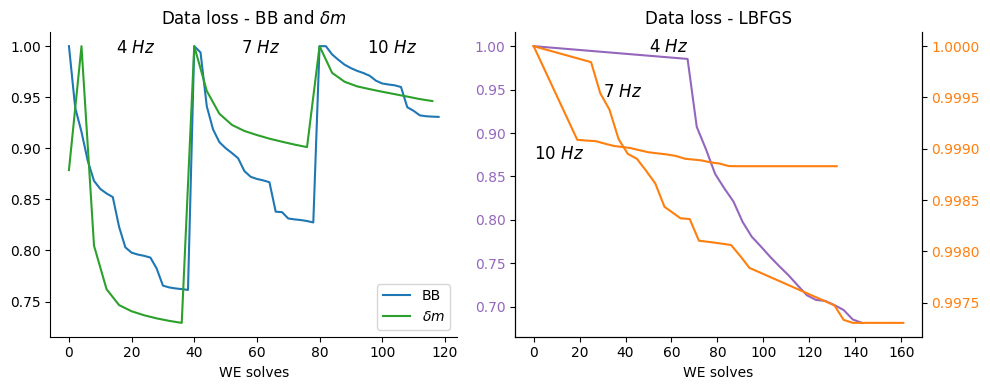

In [7]:
x1, x2 = np.arange(0, 120, 2), np.arange(0, 120, 4)
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(x1, loss_bb, label='BB')
axs[0].plot(x2, loss_dm, label=r'$\delta m$', color='tab:green')
axs[0].set_title('Data loss - BB and ' + r'$\delta m$')
axs[0].set_xlabel('WE solves')
axs[0].legend()
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].text(15, 0.993, r'$4\ Hz$', fontsize=12)
axs[0].text(55, 0.993, r'$7\ Hz$', fontsize=12)
axs[0].text(95, 0.993, r'$10\ Hz$', fontsize=12)

color = 'tab:purple'
axs[1].plot(nWE4, loss_lbfgs_4hz, color=color, label='LBFGS')
axs[1].set_title('Data loss - LBFGS')
axs[1].set_xlabel('WE solves')
axs[1].tick_params(axis='y', labelcolor=color)
axs[1].spines['top'].set_visible(False)
axs[1].text(50, 0.993, r'$4\ Hz$', fontsize=12)

ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(nWE7, loss_lbfgs_7hz, color=color)
ax2.plot(nWE10, loss_lbfgs_10hz, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['top'].set_visible(False)
ax2.text(30, 0.9995, r'$7\ Hz$', fontsize=12)
ax2.text(0.0, 0.9989, r'$10\ Hz$', fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(f'{folder_name}/losses.png',  bbox_inches='tight', dpi=300)

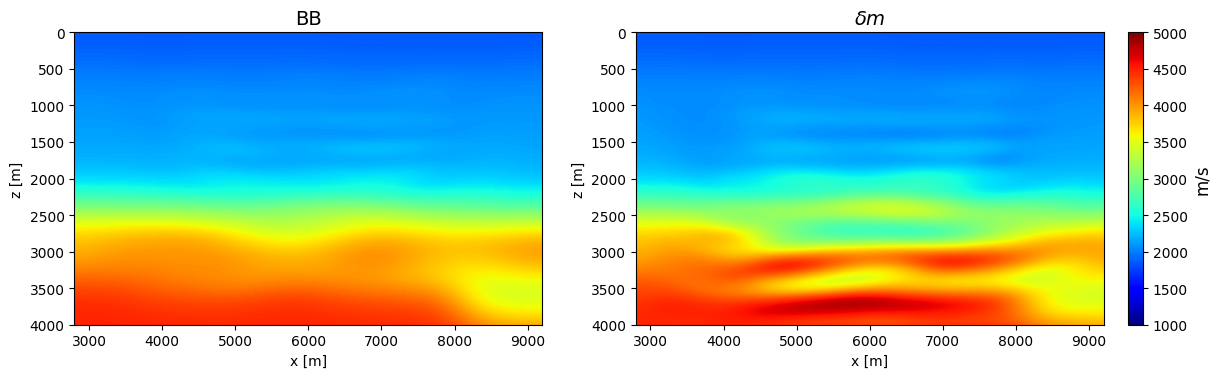

In [8]:
update_bb_1 = np.load(f'{exp1}/update_1.npy')
update_dm_1 = np.load(f'{exp3}/update_1.npy')
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
im1 = axs[0].imshow(update_bb_1, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].set_xlim(2800, 9200)
axs[0].set_ylim(4000, 0)
axs[0].set_title('BB', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(update_dm_1, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[1].set_xlim(2800, 9200)
axs[1].set_ylim(4000, 0)
axs[1].set_title(r'$\delta m$', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.38, pad=0.02).set_label(label='m/s',size=12)
plt.savefig(f'{folder_name}/volve_iter0', bbox_inches='tight', dpi=300)

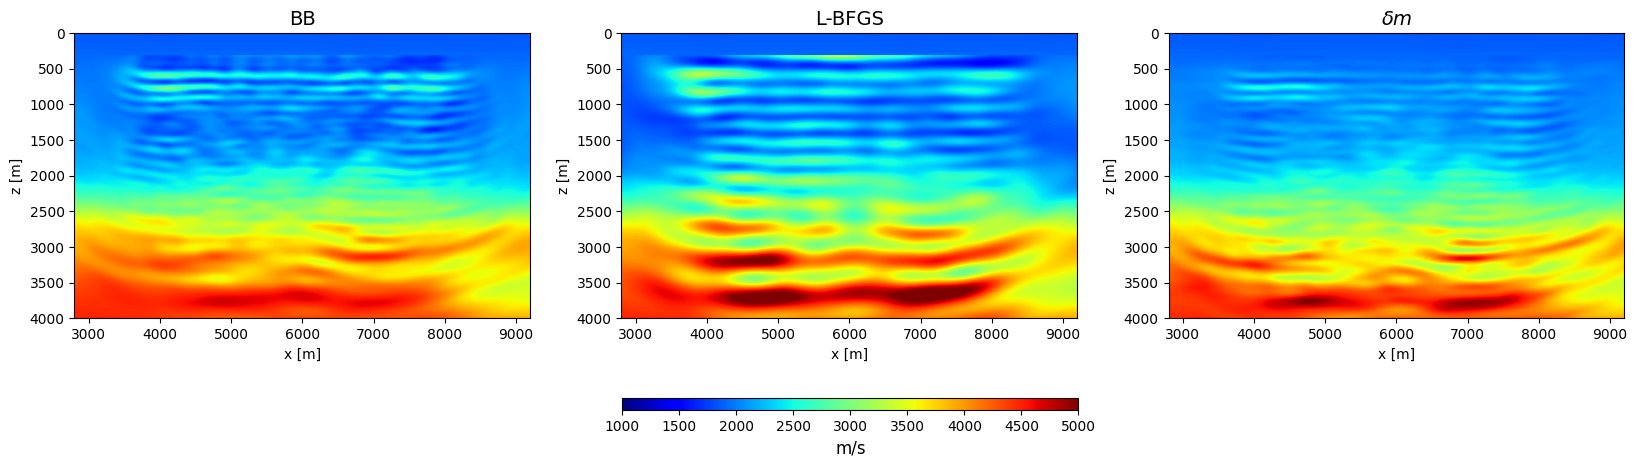

In [9]:
update_bb_last = np.load(f'{exp1}/update_last.npy')
update_lbfgs = np.load(f'{exp2}/update_10Hz.npy')
update_dm_last = np.load(f'{exp3}/update_last.npy')
fig, axs = plt.subplots(1, 3, figsize=(20, 12))
im1 = axs[0].imshow(update_bb_last, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].set_xlim(2800, 9200)
axs[0].set_ylim(4000, 0)
axs[0].set_title('BB', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(update_lbfgs, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[1].set_xlim(2800, 9200)
axs[1].set_ylim(4000, 0)
axs[1].set_title('L-BFGS', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
im3 = axs[2].imshow(update_dm_last, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[2].set_xlim(2800, 9200)
axs[2].set_ylim(4000, 0)
axs[2].set_title(r'$\delta m$', fontsize=14)
axs[2].set_xlabel(r'x [m]')
axs[2].set_ylabel(r'z [m]')
cbar_ax = fig.add_axes([0.399, 0.3, 0.228, 0.01])
fig.colorbar(im3, cax=cbar_ax, ax=axs.ravel().tolist(), shrink=0.5, pad=0.02, orientation='horizontal').set_label(label='m/s',size=12)
plt.savefig(f'{folder_name}/volve_last_iter', bbox_inches='tight', dpi=300)

In [10]:
rtm_image_init = np.load('Imaging_results/rtm_image_volve_init.npy')
rtm_image_bb = np.load('Imaging_results/rtm_image_volve_bb.npy')
rtm_image_dm = np.load('Imaging_results/rtm_image_volve_dm.npy')
rtm_image_l = np.load('Imaging_results/rtm_image_volve_lbfgs.npy')

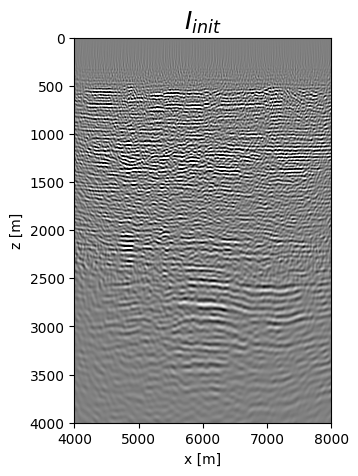

In [11]:
# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
image1 = rtm_image_init - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_init).T).T
              
clip = 3e-3
gain = np.arange(nz)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow((image1 * gain[:, np.newaxis])[:, 96:416], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc', 
          extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
ax.set_ylim(4000, 0),
ax.set_title(r'$I_{init}$', fontsize=18)
ax.set_xlabel(r'x [m]')
ax.set_ylabel(r'z [m]')
plt.savefig(f'{folder_name}/rtm_init.png', bbox_inches='tight', dpi=300)

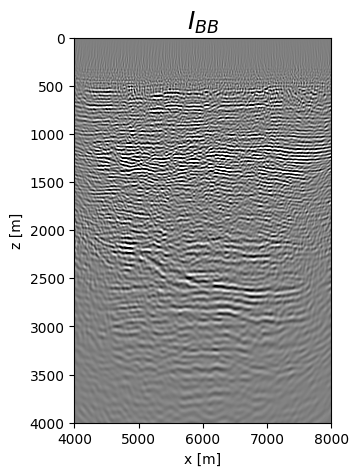

In [12]:
# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
image2 = rtm_image_bb - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_bb).T).T
            
clip = 3e-3
gain = np.arange(nz)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow((image2 * gain[:, np.newaxis])[:, 96:416], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc', 
          extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
# ax.annotate('annotate', xy=(5, 5), xytext=(15, 15), arrowprops=dict(facecolor='red', shrink=1))
# ax.annotate('', xy=(5200, 2400), xytext=(5700, 1900),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
ax.set_ylim(4000, 0),
ax.set_title(r'$I_{BB}$', fontsize=18)
ax.set_xlabel(r'x [m]')
ax.set_ylabel(r'z [m]')
plt.savefig(f'{folder_name}/rtm_bb.png', bbox_inches='tight', dpi=300)
plt.show()

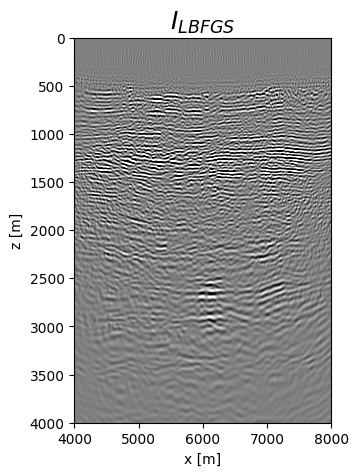

In [13]:
# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
image3 = rtm_image_l - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_l).T).T               
clip = 3e-3
gain = np.arange(nz)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow((image3 * gain[:, np.newaxis])[:, 96:416], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc', 
          extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
ax.set_ylim(4000, 0),
ax.set_title(r'$I_{LBFGS}$', fontsize=18)
ax.set_xlabel(r'x [m]')
ax.set_ylabel(r'z [m]')
plt.savefig(f'{folder_name}/rtm_lbfgs.png', bbox_inches='tight', dpi=300)

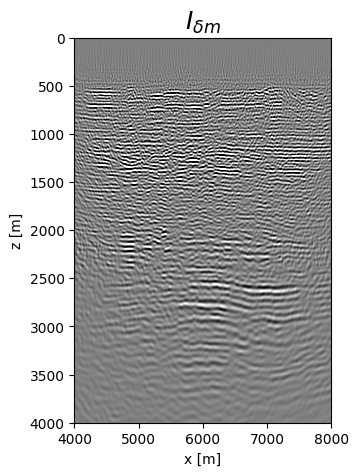

In [14]:
# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
image4 = rtm_image_dm - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_dm).T).T              
clip = 3e-3
gain = np.arange(nz)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow((image4 * gain[:, np.newaxis])[:, 96:416], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc', 
          extent=(4000, 8000, z[-1], z[0]), aspect=1.5) 
ax.set_ylim(4000, 0),
ax.set_title(r'$I_{\delta m}$', fontsize=18)
ax.set_xlabel(r'x [m]')
ax.set_ylabel(r'z [m]')
plt.savefig(f'{folder_name}/rtm_dm.png', bbox_inches='tight', dpi=300)

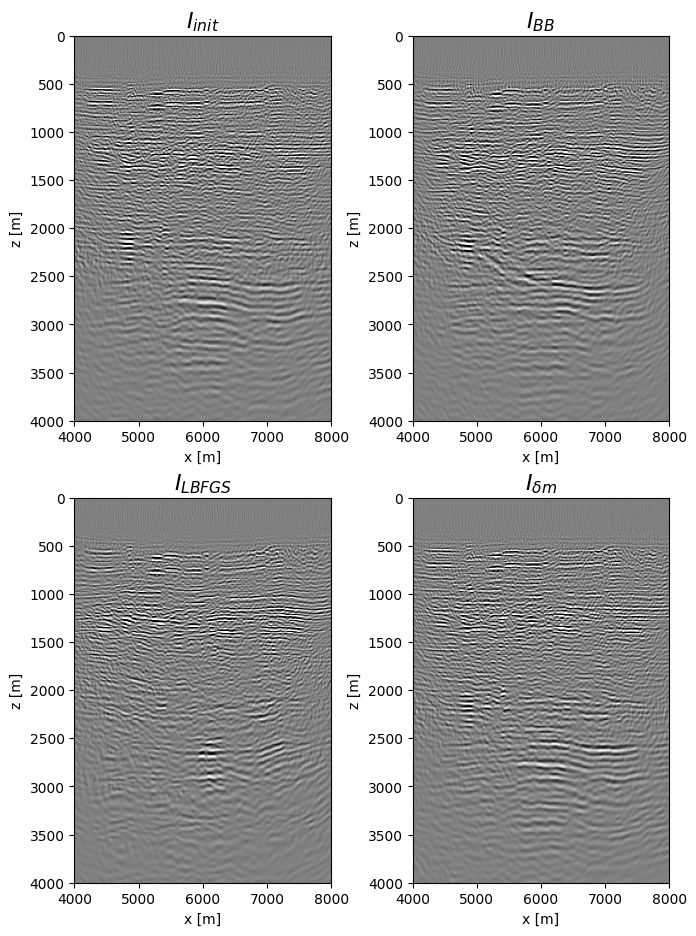

In [15]:
# artifact removal
gain = np.arange(nz)[:, np.newaxis]
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
image1 = (rtm_image_init - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_init).T).T) * gain
image2 = (rtm_image_bb - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_bb).T).T) * gain
image3 = (rtm_image_l - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_l).T).T) * gain
image4 = (rtm_image_dm - filtfilt(smooth,1,filtfilt(smooth,1,rtm_image_dm).T).T) * gain
vmax = 3e-3
fig, axs = plt.subplots(2, 2, figsize=(8, 11))
axs[0,0].imshow(image1[:, 96:416], cmap='gray', vmin=-vmax, vmax=vmax, extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
axs[0,0].set_ylim(4000, 0)
axs[0,0].set_title(r'$I_{init}$', fontsize=16)
axs[0,0].set_xlabel(r'x [m]')
axs[0,0].set_ylabel(r'z [m]')
axs[0,1].imshow(image2[:, 96:416], cmap='gray', vmin=-vmax, vmax=vmax, extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
# axs[0,1].annotate('', xy=(5200, 2400), xytext=(5700, 1900),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
# axs[0,1].set_xlim(2800, 9200)
axs[0,1].set_ylim(4000, 0)
axs[0,1].set_title(r'$I_{BB}$', fontsize=16)
axs[0,1].set_xlabel(r'x [m]')
axs[0,1].set_ylabel(r'z [m]')
axs[1,0].imshow(image3[:, 96:416], cmap='gray', vmin=-vmax, vmax=vmax, extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
axs[1,0].set_ylim(4000, 0)
axs[1,0].set_title(r'$I_{LBFGS}$', fontsize=16)
axs[1,0].set_xlabel(r'x [m]')
axs[1,0].set_ylabel(r'z [m]')
axs[1,1].imshow(image4[:, 96:416], cmap='gray', vmin=-vmax, vmax=vmax, extent=(4000, 8000, z[-1], z[0]), aspect=1.5)
# axs[1,1].annotate('', xy=(7000, 2600), xytext=(7000, 2100),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
# axs[1,1].annotate('', xy=(7000, 3500), xytext=(7000, 4000),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
axs[1,1].set_ylim(4000, 0)
axs[1,1].set_title(r'$I_{\delta m}$', fontsize=16)
axs[1,1].set_xlabel(r'x [m]')
axs[1,1].set_ylabel(r'z [m]')
plt.savefig(f'{folder_name}/rtm_images.png', bbox_inches='tight', dpi=300)

In [16]:
ext_img_init = np.load('Imaging_results/ext_img_volve_init.npy')
ext_img_bb = np.load('Imaging_results/ext_img_volve_bb.npy')
ext_img_lbfgs = np.load('Imaging_results/ext_img_volve_lbfgs.npy')
ext_img_dm = np.load('Imaging_results/ext_img_volve_dm.npy')

In [17]:
nh, _, _ = ext_img_init.shape
x_loc = (np.array([5000, 5500, 6000, 6500, 7000]) - 2800 ) // dx
x_loc = x_loc.astype(int)
x_loc

array([176, 216, 256, 296, 336])

In [18]:
adcig_init = angle_gather(ext_img_init, model_init, 12.5, 60, x_loc)
# np.save(f'{folder_name}/adcig_init', adcig_init)

model_bb_sm = gaussian_filter(update_bb_last, [4, 10])
adcig_bb = angle_gather(ext_img_bb, model_bb_sm, 12.5, 60, x_loc)
# np.save(f'{folder_name}/adcig_bb', adcig_bb)

model_lbfgs_sm = gaussian_filter(update_lbfgs, [4, 10])
adcig_lbfgs = angle_gather(ext_img_lbfgs, model_lbfgs_sm, 12.5, 60, x_loc)
# np.save(f'{folder_name}/adcig_lbfgs', adcig_lbfgs)

model_dm_sm = gaussian_filter(update_dm_last, [4, 10])
adcig_dm = angle_gather(ext_img_dm, model_dm_sm, 12.5, 60, x_loc)
# np.save(f'{folder_name}/adcig_dm', adcig_dm)

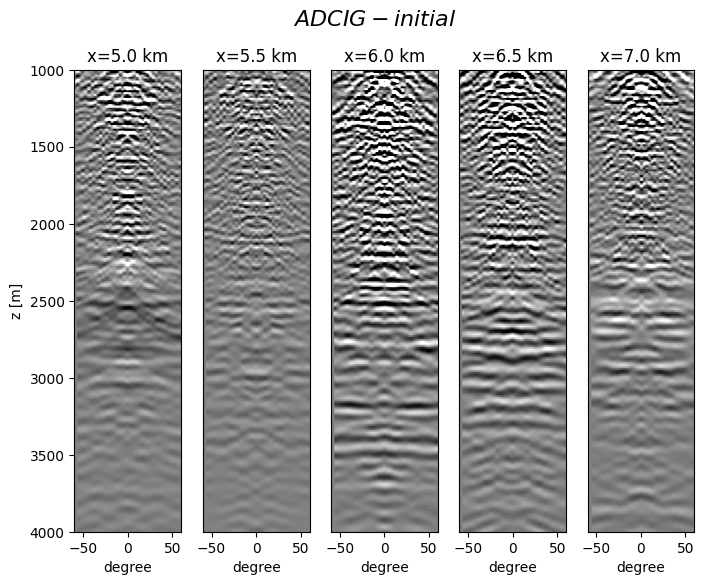

In [19]:
x_loc2 = [5.0, 5.5, 6.0, 6.5, 7.0]
clip = 0.05
fig, axs = plt.subplots(1, 5, figsize=(8, 6))
for ix in range(5):
    max_val = np.abs(adcig_init[ix]).max()
    axs[ix].imshow(adcig_init[ix][80:], cmap='gray', vmin=-max_val*clip, vmax=max_val*clip, 
                   extent=(-60, 60, nz*dx, 1000), aspect='auto')
    axs[ix].set_title(f'x={x_loc2[ix]} km')
    axs[ix].set_xlabel(r'degree')
    axs[ix].set_ylim(4000, 1000)
    if ix != 0: axs[ix].get_yaxis().set_ticks([])
    if ix == 0: axs[ix].set_ylabel(r'z [m]')
fig.suptitle(r'$ADCIG - initial$', fontsize=16)
plt.savefig(f'{folder_name}/adcig_init.png', bbox_inches='tight', dpi=300)

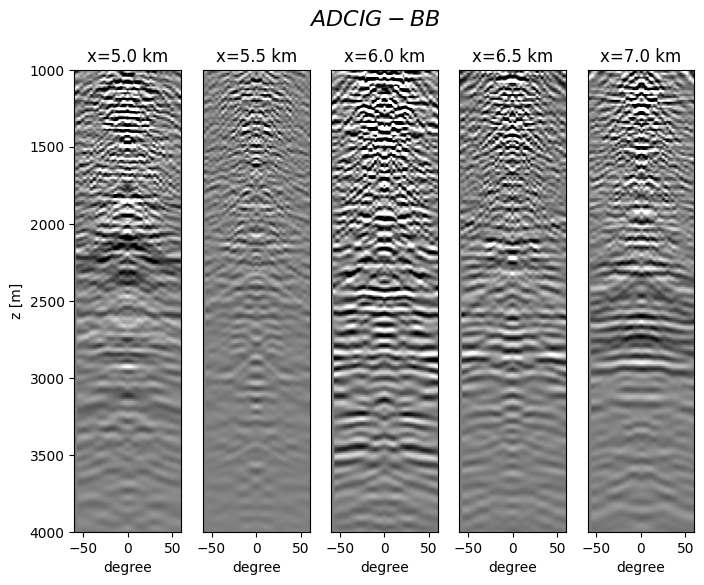

In [20]:
clip = 0.05
fig, axs = plt.subplots(1, 5, figsize=(8, 6))
for ix in range(5):
    max_val = np.abs(adcig_bb[ix]).max()
    axs[ix].imshow(adcig_bb[ix][80:], cmap='gray', vmin=-max_val*clip, vmax=max_val*clip, 
                   extent=(-60, 60, nz*dx, 1000), aspect='auto')
    axs[ix].set_title(f'x={x_loc2[ix]} km')
    axs[ix].set_xlabel(r'degree')
    axs[ix].set_ylim(4000, 1000)
    if ix != 0: axs[ix].get_yaxis().set_ticks([])
    if ix == 0: axs[ix].set_ylabel(r'z [m]')
# axs[2].annotate('', xy=(-20, 3300), xytext=(0, 3500),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
# axs[2].annotate('', xy=(-20, 3500), xytext=(0, 3700),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
fig.suptitle(r'$ADCIG - BB$', fontsize=16)
plt.savefig(f'{folder_name}/adcig_bb.png', bbox_inches='tight', dpi=300)

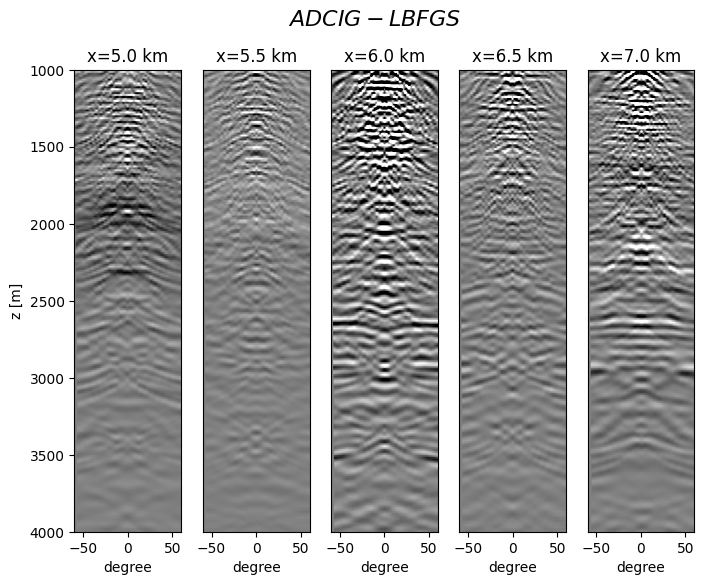

In [21]:
clip = 0.05
fig, axs = plt.subplots(1, 5, figsize=(8, 6))
for ix in range(5):
    max_val = np.abs(adcig_lbfgs[ix]).max()
    axs[ix].imshow(adcig_lbfgs[ix][80:], cmap='gray', vmin=-max_val*clip, vmax=max_val*clip, 
                   extent=(-60, 60, nz*dx, 1000), aspect='auto')
    axs[ix].set_title(f'x={x_loc2[ix]} km')
    axs[ix].set_xlabel(r'degree')
    axs[ix].set_ylim(4000, 1000)
    if ix != 0: axs[ix].get_yaxis().set_ticks([])
    if ix == 0: axs[ix].set_ylabel(r'z [m]')
# axs[2].annotate('', xy=(-20, 3500), xytext=(0, 3700),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
fig.suptitle(r'$ADCIG - LBFGS$', fontsize=16)
plt.savefig(f'{folder_name}/adcig_lbfgs.png', bbox_inches='tight', dpi=300)

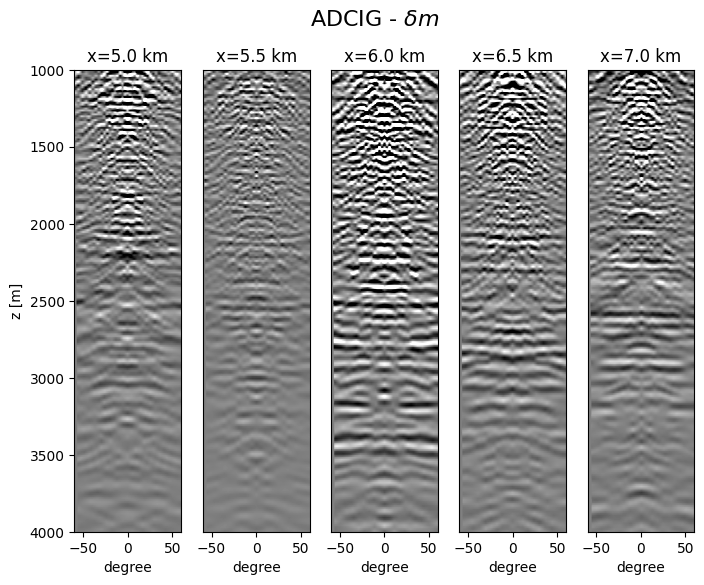

In [22]:
clip = 0.05
fig, axs = plt.subplots(1, 5, figsize=(8, 6))
for ix in range(5):
    max_val = np.abs(adcig_dm[ix]).max()
    axs[ix].imshow(adcig_dm[ix][80:], cmap='gray', vmin=-max_val*clip, vmax=max_val*clip, 
                   extent=(-60, 60, nz*dx, 1000), aspect='auto')
    axs[ix].set_title(f'x={x_loc2[ix]} km')
    axs[ix].set_xlabel(r'degree')
    axs[ix].set_ylim(4000, 1000)
    if ix != 0: axs[ix].get_yaxis().set_ticks([])
    if ix == 0: axs[ix].set_ylabel(r'z [m]')
# axs[1].annotate('', xy=(0, 2600), xytext=(20, 2800),
#         arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
# axs[4].annotate('', xy=(-40, 2600), xytext=(-20, 2800),
#             arrowprops=dict(facecolor='red', shrink=0.1, width=2, headwidth=10))
fig.suptitle(r'ADCIG - $\delta m$', fontsize=16)
plt.savefig(f'{folder_name}/adcig_dm.png', bbox_inches='tight', dpi=300)